In [150]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report


### Lendo o arquivo 

In [151]:
df_car = pd.read_csv("car_ad.csv")

### Identificando colunas e dados

In [152]:
df_car.head(1)

,car,price,body,mileage,engV,engType,registration,year,model,drive
0,Ford,15500.0,crossover,68,2.5,Gas,yes,2010,Kuga,full


#### Verificando Quantidade de dados (RangeIndex), Quantidade colunas (Data Columns), As columns, quantidade de dados NaN ou Null e o Dtype

In [153]:
df_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9576 entries, 0 to 9575
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   car           9576 non-null   object 
 1   price         9576 non-null   float64
 2   body          9576 non-null   object 
 3   mileage       9576 non-null   int64  
 4   engV          9142 non-null   float64
 5   engType       9576 non-null   object 
 6   registration  9576 non-null   object 
 7   year          9576 non-null   int64  
 8   model         9576 non-null   object 
 9   drive         9065 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 748.2+ KB


###### Optei por não utilizar as colunas registration e mileage, registration, diz respeito a se o veiculo é ou não registrado na Ucrania, mileage diz respeito a km rodada a permanencia desta estava afetando a acuracia. Estou eliminando os dados 'Other' da coluna Body, e as linhas cujos valores da coluna drive sejam nulos. Entendo que other e dados nulos na coluna driver, podem impactar negativamente em minha analise. Também removo outliers, onde os valores de engV estão limitados a 0.8 - 8, essa alteração foi motivada pela pesquisa que fiz e analisando os dados.

In [154]:
df_car = df_car.query("body != 'other' & drive.notnull() & engV > 0.8 & engV < 7.5").drop(["registration","mileage"], axis = 1).reset_index(drop=True)

In [155]:
# list_columns = ["price","engV","engType","drive"]

# df_car = df_car.drop_duplicates()

##### verificando se alguma coluna ainda possui valores NaN, verifiquei que não

In [156]:
df_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7923 entries, 0 to 7922
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   car      7923 non-null   object 
 1   price    7923 non-null   float64
 2   body     7923 non-null   object 
 3   engV     7923 non-null   float64
 4   engType  7923 non-null   object 
 5   year     7923 non-null   int64  
 6   model    7923 non-null   object 
 7   drive    7923 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 495.3+ KB


#### Convertendo a coluna price e engV em int, para teste.

In [157]:
df_car['price'] = df_car['price'].astype(int)

df_car['engV'] = df_car["engV"]*10

df_car['engV'] = df_car["engV"].astype(int)

In [158]:
df_car = df_car.sort_values(['body']).reset_index(drop = True)

In [159]:
list_cars_body = df_car['body'].unique()

list_cars_body

array(['crossover', 'hatch', 'sedan', 'vagon', 'van'], dtype=object)

# Transformando os dados str em int 

In [160]:
label_encoder = preprocessing.LabelEncoder()
  
df_car['body']= label_encoder.fit_transform(df_car['body'])
df_car['model'] = label_encoder.fit_transform(df_car['model'])
df_car['car']= label_encoder.fit_transform(df_car['car'])
df_car['engType']= label_encoder.fit_transform(df_car['engType'])
df_car['drive']= label_encoder.fit_transform(df_car['drive'])

In [161]:
df_car['body'].unique()

# 'crossover' = 0
# 'sedan' = 2
# 'van' = 4
# 'vagon' = 3
# 'hatch' = 1

array([0, 1, 2, 3, 4])

In [162]:
df_car.sort_values(['year'])

,car,price,body,engV,engType,year,model,drive
5894,22,259,2,24,2,1959,29,2
3537,22,500,2,20,2,1961,29,2
6060,22,15000,2,25,3,1963,29,2
2221,48,1500,1,14,3,1964,96,2
3796,22,0,2,24,3,1969,29,0
...,...,...,...,...,...,...,...,...
1099,45,0,0,30,0,2016,339,1
7587,14,14849,4,16,0,2016,191,0
3340,71,13893,2,16,3,2016,544,0
1838,53,99999,0,29,0,2016,235,1


#### Gráficos utilizados para analisar

In [163]:
# plt.figure(figsize=(20, 10))
# plt.plot(df_car['price'])
# plt.show()

# plt.figure(figsize=(15, 10))
# plt.hist(df_car['price'], 10, rwidth=0.9)
# plt.show()

# sns.boxplot(df_car['engV'])

#### DFs utilizados para normalização, e posterior normalização dos dados

In [164]:
df_car_sem_body = df_car.drop(['body'], axis = 1)

In [165]:
df_car_body = df_car[["body"]]

In [166]:
scaler = MaxAbsScaler()  
scaler.fit(df_car_sem_body)
df_car_sem_body_normalizado = scaler.transform(df_car_sem_body)

In [167]:
X_train, X_test, y_train, y_test = train_test_split(df_car_sem_body_normalizado, df_car_body, test_size = 0.2)

In [168]:
oversample = SMOTE()
X_train_Smote, y_train_Smote = oversample.fit_resample(X_train, y_train)

In [169]:
knn_model = KNeighborsRegressor(n_neighbors = 1)


knn_model.fit(X_train_Smote, y_train_Smote)


y_pred = knn_model.predict(X_test)



In [170]:
y_pred = pd.DataFrame(y_pred)

y_pred = y_pred.astype(int)

print(classification_report(y_pred, y_test))

from sklearn.metrics import confusion_matrix

matriz = confusion_matrix(y_pred, y_test)


              precision    recall  f1-score   support

           0       0.94      0.95      0.94       400
           1       0.68      0.63      0.65       212
           2       0.79      0.86      0.82       618
           3       0.45      0.33      0.38       171
           4       0.82      0.83      0.83       184

    accuracy                           0.79      1585
   macro avg       0.74      0.72      0.73      1585
weighted avg       0.78      0.79      0.78      1585



<AxesSubplot:>

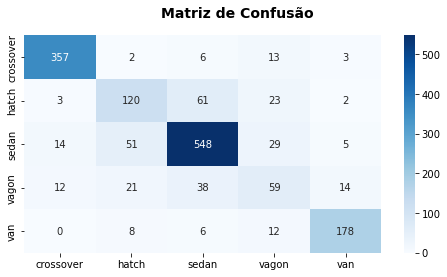

In [149]:
fig = plt.figure(figsize=(8,4))
fig.suptitle('Matriz de Confusão ', fontsize=14, fontweight='bold')
sns.heatmap(matriz,annot=True, fmt="d",cmap='Blues',xticklabels= list_cars_body, yticklabels= list_cars_body)